<a href="https://colab.research.google.com/github/lfyamagawa/biblioteca/blob/master/FRL_CD_AM2_06_2_MAML_LFY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAML
## Dataset
Usar o dataset Omniglot (padrão em meta-aprendizado)
## Tarefa
Treinar um modelo para classificar novas classes com poucos exemplos

## Explicação do código
1. Geração de Tarefas:
- A função generate_sine_task cria tarefas de regressão senoidal. Cada tarefa é uma função seno com amplitude e fase aleatórias.
- Para cada tarefa, geramos um support set (usado para adaptação) e um query set (usado para avaliar a adaptação).
2. Modelo:
- O modelo é uma rede neural simples com duas camadas ocultas (40 neurônios cada) e uma camada de saída para regressão.
- A função de perda é o erro quadrático médio (MSE).
3. Treinamento com MAML:
- O MAML tem dois loops:
  - Inner loop: adapta o modelo ao support set de uma tarefa específica usando k iterações de gradiente (aqui, k=5).
  - Outer loop: atualiza os pesos iniciais do modelo para minimizar a perda no query set, tornando o modelo "bom em se adaptar".
- A função train_maml implementa esse processo para 1000 tarefas.
4. Visualização:
- A função visualize_adaptation mostra como o modelo se adapta a uma nova tarefa:
  - Gera uma nova tarefa com 10 pontos no support set.
  - Plota a previsão do modelo antes e depois da adaptação (com 5 iterações de gradiente).
  - Compara com a função verdadeira.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Tarefa 0, Perda no Query Set: 0.8611
Tarefa 100, Perda no Query Set: 0.2912
Tarefa 200, Perda no Query Set: 0.1924
Tarefa 300, Perda no Query Set: 1.9337
Tarefa 400, Perda no Query Set: 6.6407
Tarefa 500, Perda no Query Set: 0.9371
Tarefa 600, Perda no Query Set: 0.3960
Tarefa 700, Perda no Query Set: 5.0780
Tarefa 800, Perda no Query Set: 0.5178
Tarefa 900, Perda no Query Set: 2.3644


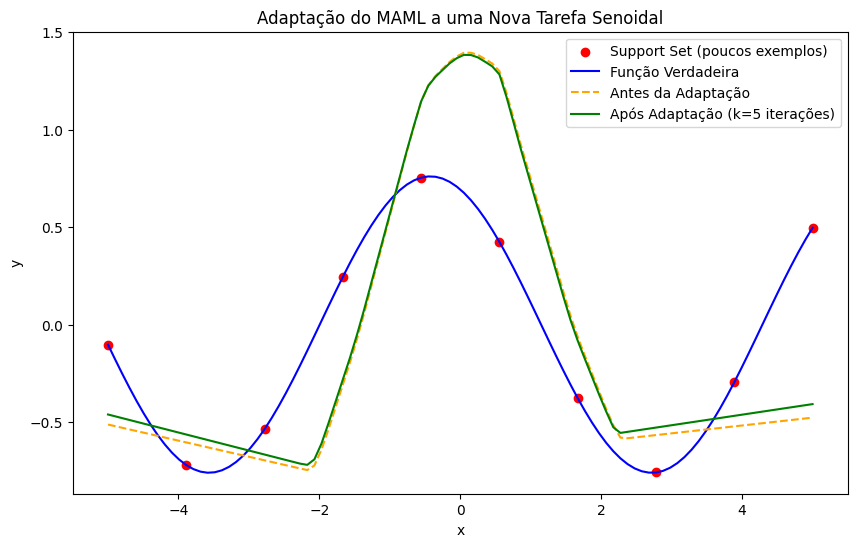

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Função para gerar tarefas de regressão senoidal
def generate_sine_task(n_samples=10, amplitude=None, phase=None):
    """
    Gera uma tarefa de regressão senoidal com amplitude e fase aleatórias.
    Retorna: (x, y) onde x é o input e y é a saída (seno).
    """
    if amplitude is None:
        amplitude = np.random.uniform(0.1, 5.0)  # Amplitude entre 0.1 e 5.0
    if phase is None:
        phase = np.random.uniform(0, np.pi)      # Fase entre 0 e π
    x = np.linspace(-5, 5, n_samples)           # Pontos no intervalo [-5, 5]
    y = amplitude * np.sin(x + phase)            # Função seno
    return x, y, amplitude, phase

# Definir o modelo (uma rede neural simples)
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(40, activation='relu', input_shape=(1,)),
        tf.keras.layers.Dense(40, activation='relu'),
        tf.keras.layers.Dense(1)  # Saída: valor predito (regressão)
    ])
    return model

# Função para calcular a perda (MSE)
def compute_loss(model, x, y):
    x = x.reshape(-1, 1)  # Garantir shape (n_samples, 1)
    y = y.reshape(-1, 1)
    y_pred = model(x, training=True)
    return tf.reduce_mean(tf.square(y_pred - y))

# Função para atualizar os pesos do modelo (inner loop do MAML)
def inner_update(model, x, y, alpha=0.01, k=1):
    """
    Realiza k iterações de gradiente no inner loop para adaptar o modelo a uma tarefa.
    alpha: taxa de aprendizado do inner loop
    k: número de iterações de gradiente
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, y)
    gradients = tape.gradient(loss, model.trainable_variables)
    updated_weights = []
    for w, g in zip(model.trainable_variables, gradients):
        updated_weights.append(w - alpha * g)
    return updated_weights

# Função para aplicar os pesos atualizados a um modelo
def set_weights(model, weights):
    for w, new_w in zip(model.trainable_variables, weights):
        w.assign(new_w)

# Função para treinar o MAML (outer loop)
def train_maml(model, n_tasks=1000, meta_lr=0.001, inner_lr=0.01, k=5, n_samples=10):
    """
    Treina o modelo com MAML.
    n_tasks: número de tarefas para o meta-treinamento
    meta_lr: taxa de aprendizado do outer loop
    inner_lr: taxa de aprendizado do inner loop
    k: número de iterações no inner loop
    n_samples: número de amostras por tarefa
    """
    optimizer = tf.keras.optimizers.Adam(learning_rate=meta_lr)

    for task in range(n_tasks):
        # Gerar uma tarefa de treinamento (support set e query set)
        x_support, y_support, _, _ = generate_sine_task(n_samples=n_samples)
        x_query, y_query, _, _ = generate_sine_task(n_samples=n_samples)

        # Copiar os pesos originais do modelo
        original_weights = [w.numpy() for w in model.trainable_variables]

        # Inner loop: adaptar o modelo ao support set
        updated_weights = inner_update(model, x_support, y_support, alpha=inner_lr, k=k)

        # Aplicar os pesos atualizados para calcular a perda no query set
        set_weights(model, updated_weights)
        with tf.GradientTape() as tape:
            query_loss = compute_loss(model, x_query, y_query)

        # Calcular gradientes em relação aos pesos originais
        set_weights(model, original_weights)  # Restaurar pesos originais
        gradients = tape.gradient(query_loss, model.trainable_variables)

        # Atualizar os pesos originais (outer loop)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        if task % 100 == 0:
            print(f"Tarefa {task}, Perda no Query Set: {query_loss.numpy():.4f}")

# Função para visualizar a adaptação do modelo a uma nova tarefa
def visualize_adaptation(model, x_support, y_support, x_test, y_test, inner_lr=0.01, k=5):
    """
    Visualiza como o modelo se adapta a uma nova tarefa com poucas iterações.
    """
    # Fazer uma cópia do modelo para adaptação
    adapted_model = create_model()
    adapted_model.set_weights(model.get_weights())

    # Prever antes da adaptação
    x_test_reshaped = x_test.reshape(-1, 1)
    y_pred_before = adapted_model(x_test_reshaped, training=False).numpy()

    # Adaptar o modelo ao support set
    updated_weights = inner_update(adapted_model, x_support, y_support, alpha=inner_lr, k=k)
    set_weights(adapted_model, updated_weights)

    # Prever após a adaptação
    y_pred_after = adapted_model(x_test_reshaped, training=False).numpy()

    # Plotar os resultados
    plt.figure(figsize=(10, 6))
    plt.scatter(x_support, y_support, c='red', label='Support Set (poucos exemplos)')
    plt.plot(x_test, y_test, label='Função Verdadeira', color='blue')
    plt.plot(x_test, y_pred_before, label='Antes da Adaptação', color='orange', linestyle='--')
    plt.plot(x_test, y_pred_after, label='Após Adaptação (k=5 iterações)', color='green')
    plt.legend()
    plt.title("Adaptação do MAML a uma Nova Tarefa Senoidal")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

# Configurar e treinar o modelo
model = create_model()
train_maml(model, n_tasks=1000, meta_lr=0.001, inner_lr=0.01, k=5, n_samples=10)

# Testar a adaptação em uma nova tarefa
x_support, y_support, amp, phase = generate_sine_task(n_samples=10)  # Support set (poucos exemplos)
x_test, y_test, _, _ = generate_sine_task(n_samples=100, amplitude=amp, phase=phase)  # Test set (mais pontos para visualização)
visualize_adaptation(model, x_support, y_support, x_test, y_test, inner_lr=0.01, k=5)

## 6.2: análise de MAML
O MAML demonstra capacidade de adaptação inicial (Tarefas 0–200), mas sofre com instabilidade devido a desafios na otimização ou diversidade de tarefas. A presença de picos sugere que o modelo ainda não generaliza bem para todas as tarefas, exigindo ajustes no treinamento ou arquitetura.